# data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

In [2]:
# create a plot of generated images (reversed grayscale)
def show_plot(examples, n, with_channel=True):
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        if with_channel:
            # shape = (n_sample, x_axis, y_axis, channel)
            plt.imshow(examples[i, :, :, 0], cmap='gray_r')
        else:
            # shape = (n_sample, x_axis, y_axis)
            plt.imshow(examples[i], cmap='gray_r')
            
    plt.show()
    
def t_sne_visualize(x, y):
    tsne = TSNE(n_components=2, random_state=0)
    tsne_obj = tsne.fit_transform(x)

    tsne_df = pd.DataFrame({'X': tsne_obj[:, 0],
                            'Y': tsne_obj[:, 1],
                            'classes': y})
    sns.scatterplot(x="X", y="Y",
                    hue="classes",
                    legend='full',
                    size=0.5,
                    alpha=0.2,
                    data=tsne_df)
    plt.show()

In [3]:
from keras.datasets import mnist
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# data pre-processing
# flat the input data
x_train = x_train.reshape(*x_train.shape, 1) / 255.    # normalize
x_test = x_test.reshape(*x_test.shape, 1) / 255.      # normalize

# one-hot output data
# y_train = to_categorical(y_train, num_classes=10)
# y_test = to_categorical(y_test, num_classes=10)

Using TensorFlow backend.
/home/congyu/.virtualenvs/congyuml/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/congyu/.virtualenvs/congyuml/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/congyu/.virtualenvs/congyuml/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/congyu/.virtua

# trival autoencoder

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model

In [ ]:
# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)


# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))


In [ ]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=30,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

In [ ]:
# encode and decode some digits
# note that we take them from the *test* set

# encoded_imgs = encoder.predict(x_test)
# decoded_imgs = decoder.predict(encoded_imgs)

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# convolutional autoencoder

In [4]:
from keras.layers import (Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, 
                          Conv2DTranspose, BatchNormalization, Flatten, Reshape)
from keras.models import Model, Sequential
from keras import backend as K

In [ ]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=30,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1 )
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# convolutional autoencoder (version 2)

In [5]:
# ENCODER
inp = Input((28, 28, 1))
e = Conv2D(32, (3, 3), activation='relu')(inp)
e = MaxPooling2D((2, 2))(e)
e = Conv2D(64, (3, 3), activation='relu')(e)
e = MaxPooling2D((2, 2))(e)
e = Conv2D(64, (3, 3), activation='relu')(e)
l = Flatten()(e)

# l = Dense(49, activation='relu')(l)
l = Dense(49, activation='softmax')(l)

encoder = Model(inp, l)


# DECODER
l = Input((49,))
d = Reshape((7, 7, 1))(l)
d = Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(d)
d = BatchNormalization()(d)
d = Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(d)
d = BatchNormalization()(d)
d = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(d)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(d)

decoder = Model(l, decoded)

autoencoder = Sequential()
autoencoder.add(encoder)
autoencoder.add(decoder)

autoencoder.compile(optimizer='adam', loss='mse') 

In [6]:
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [7]:
autoencoder.fit(x_train, x_train,
                epochs=30,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))


Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 8s 128us/step - loss: 0.0266 - val_loss: 0.1593
Epoch 2/30
60000/60000 [==============================] - 8s 136us/step - loss: 0.0117 - val_loss: 0.0108
Epoch 3/30
60000/60000 [==============================] - 9s 142us/step - loss: 0.0101 - val_loss: 0.0119
Epoch 4/30
60000/60000 [==============================] - 9s 144us/step - loss: 0.0093 - val_loss: 0.0086
Epoch 5/30
60000/60000 [==============================] - 8s 137us/step - loss: 0.0087 - val_loss: 0.0088
Epoch 6/30
60000/60000 [==============================] - 8s 139us/step - loss: 0.0082 - val_loss: 0.0224
Epoch 7/30
60000/60000 [==============================] - 8s 137us/step - loss: 0.0080 - val_loss: 0.0081
Epoch 8/30
60000/60000 [==============================] - 8s 135us/step - loss: 0.0077 - val_loss: 0.0130
Epoch 9/30
60000/60000 [==============================] - 8s 134us/step - loss: 0.0075 - val_loss: 0.

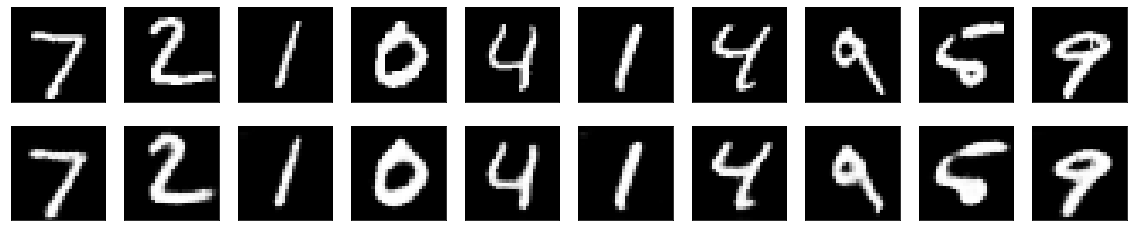

In [8]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1 )
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# variational autoencoder (version 1 - old version)

In [ ]:
# https://tiao.io/post/tutorial-on-variational-autoencoders-with-a-concise-keras-implementation/

In [ ]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Layer, Lambda, Add, Multiply
from keras import backend as K
from keras.losses import mse, binary_crossentropy

In [ ]:
def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)


def nll2(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """
    
    # Why this do not work ??
    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.binary_crossentropy(y_true, y_pred)

class KLDivergenceLayer(Layer):

    """ 
    This Layer did nothing but add KL loss
    
    Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs

In [ ]:
original_dim = np.prod(x_train.shape[1:])
latent_dim = 2
intermediate_dim = 512


x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

eps = Input(tensor=K.random_normal(shape=(K.shape(x)[0], latent_dim)))
z_eps = Multiply()([z_sigma, eps])
z = Add()([z_mu, z_eps])

decoder = Sequential([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(original_dim, activation='sigmoid')
])

x_pred = decoder(z)

encoder = Model(x, z_mu)

vae = Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='rmsprop', loss=nll)

In [ ]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

hist = vae.fit(x_train,
        x_train,
        shuffle=True,
        epochs=30,
        batch_size=128,
        validation_data=(x_test, x_test))



In [ ]:
pd.DataFrame(hist.history).plot() 

In [ ]:
# display a 2D plot of the digit classes in the latent space
z_test = encoder.predict(x_test, batch_size=128)
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test,
            alpha=.4, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

In [ ]:
from scipy.stats import norm

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian

z1 = norm.ppf(np.linspace(0.01, 0.99, n))
z2 = norm.ppf(np.linspace(0.01, 0.99, n))
z_grid = np.dstack(np.meshgrid(z1, z2))

x_pred_grid = decoder.predict(z_grid.reshape(n*n, latent_dim)) \
                     .reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_pred_grid))), cmap='gray')
plt.show()

# (convolutional) variational autoencoder (version2 - new version, base on tensorflow)

In [ ]:
import tensorflow as tf
import keras
from keras import layers

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    

latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
    
    def call(self, x):
        return self.decoder(self.encoder(x)[-1])
    
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [ ]:
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

vae.fit(x_train, x_train,
        shuffle=True,
        epochs=30,
        batch_size=128,
        validation_data=(x_test, x_test))

In [ ]:
def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    
    # start_range = digit_size // 2
    # end_range = n * digit_size + start_range + 1
    # pixel_range = np.arange(start_range, end_range, digit_size)
    # sample_range_x = np.round(grid_x, 1)
    # sample_range_y = np.round(grid_y, 1)
    # plt.xticks(pixel_range, sample_range_x)
    # plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder)